# ML on Kickstarter projects

We aim at predicting if a kickstarter project is going to achieve is goal or not. We are going to do this by building a model out of a dataset scrapped on Kickstarter's website in january 2018.

## Table of Contents:
**[I. Data loading and overview](#one)**
- [a. Loading the data](#one-a)
- [b. Overview](#one-b)

**[II. Data cleaning](#two)**
- [a. Duplicated and missing values](#two-a)
- [b. Deal with outliers](#two-b)

**[III. Features engineering](#three)**
- [a. Target](#three-a)
- [b. Deal with categorical features](#three-b)

- [e. Correlations and dimensionality reductions](#three-e)

**[IV. Model selection](#four)**
- [a. Split](#four-a)
- [b. Metrics](#four-b)
- [c. Models](#four-c)
- [d. Cross-validation](#four-d)

**[V. Hyperparameters tuning](#five)**

**[VI. Training and predictions](#six)**

## I. Data loading and overview <a id="one"></a>

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

### a. Loading the data <a id="one-a"></a>

In [2]:
FILEPATH = os.path.join('data', 'dataset.csv')

df = pd.read_csv(FILEPATH, index_col=0)
df.head(2)

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00


### b. Overview <a id="one-b"></a>

Colonne | Description
------- | -------
**ID** | internal kickstarter id
**name** | name of project - a project is a finite work with a clear goal that you’d like to bring to life. Think albums, books, or films
**category** | category
**main_category** | category of campaign
**currency** | currency used to support
**deadline** | deadline for crowdfunding
**goal** | fundraising goal - the funding goal is the amount of money that a creator needs to complete their project
**launched** | date launched
**pledged** | pledged amount in the project currency
**state** | current condition the project is in
**backers** | number of backers
**country** | country pledged from
**usd pledged** | amount of money pledged in USD (conversion made by Kickstarter)
**usd_pledged_real** | amount of money pledged in USD (conversion made by fixer.io api)
**usd_goal_real** | goal amount in USD (conversion made by fixer.io api)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378661 entries, 1000002330 to 999988282
Data columns (total 14 columns):
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(1), object(8)
memory usage: 43.3+ MB


In [4]:
df.describe()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


We only keep the `_real` features as amounts are fixed by fixer.io API. We also remove `usd_pledged_real` because we won't have this information when trying to predict the final state of a new project.

In [5]:
df.drop(['pledged'], axis=1, inplace=True)
df.drop(['usd pledged'], axis=1, inplace=True)
df.drop(['usd_pledged_real'], axis=1, inplace=True)
df.drop(['goal'], axis=1, inplace=True)

## II. Data cleaning <a id="two"></a>

### a. Duplicated and missing values <a id="two-a"></a>

In [6]:
#Count the number of duplicated rows
df.duplicated().sum()

0

In [7]:
#Count the number of NaN values for each column
df.isna().sum()

name             4
category         0
main_category    0
currency         0
deadline         0
launched         0
state            0
backers          0
country          0
usd_goal_real    0
dtype: int64

There are missing values for `name`, let's drop the rows concerned.

In [8]:
#Drop all NaN values
df = df.dropna()

### b. Deal with outliers <a id="two-b"></a>

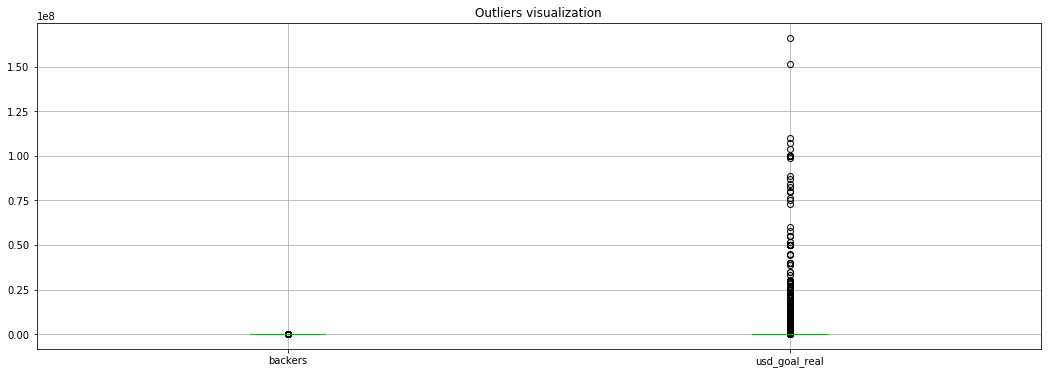

In [9]:
#Visualize univariate outliers
plt.subplots(figsize=(18,6))
plt.title("Outliers visualization")
df.boxplot();

In [10]:
#Take a deeper look at univariate outliers
i = 0
for row in df['usd_goal_real']:
    if row > 100000000:
        print(df.iloc[i])
    i += 1

name             FUCK Potato Salad. Paleo Potato Brownies!
category                                              Food
main_category                                         Food
currency                                               GBP
deadline                                        2014-08-08
launched                               2014-07-09 00:24:34
state                                               failed
backers                                                  0
country                                                 GB
usd_goal_real                                  1.66361e+08
Name: 1243678698, dtype: object
name              A Celtic Lovestory
category                       Drama
main_category           Film & Video
currency                         GBP
deadline                  2015-11-30
launched         2015-11-17 00:47:15
state                         failed
backers                            0
country                           GB
usd_goal_real            1.51396e+08
Name: 20

In [11]:
#Count the number of 1$ dollar (or less) projects.
i = 0
for row in df['usd_goal_real']:
    if row <= 1:
        i += 1
print(i)

373


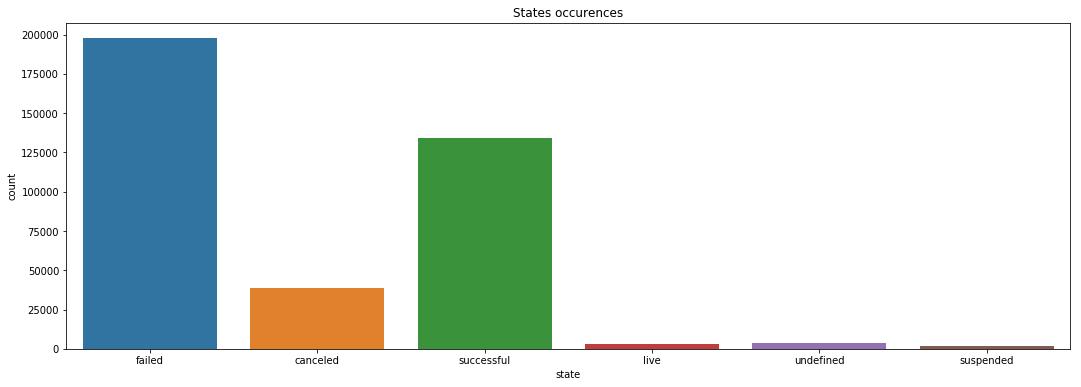

In [12]:
#Visualize the state of these rows.
one_dollar = {}
one_dollar = pd.DataFrame(data=one_dollar)
for row in df['usd_goal_real']:
    if row <= 1:
        one_dollar = df

fig, ax = plt.subplots(figsize=(18, 6))
sns.countplot(one_dollar['state'], ax=ax).set_title('States occurences');

This histogram showing states of one-dollar projects looks like the one I made below for the entire dataset. So it might not help to create $1 dollar projects. Now let's get rid of univariate outliers to build a better model.

In [13]:
#Delete univariate outliers using sigma-clipping operations
quartiles = np.percentile(df['usd_goal_real'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])

df = df.query('(usd_goal_real > @mu - 5 * @sig) & (usd_goal_real < @mu + 5 * @sig)')

In [14]:
#Delete univariate outliers using IQR
quartiles = np.percentile(df['usd_goal_real'], [25, 50, 75])
Q1 = quartiles[0]
Q3 = quartiles[2]
IQR = Q3 - Q1

df = df.query('(usd_goal_real > (@Q1 - 1.5 * @IQR)) & (usd_goal_real < (@Q3 + 1.5 * @IQR))')

In [15]:
#Visualize multivariate outliers
#sns.pairplot(data=df, hue="state");

## III. Features engineering <a id="three"></a>

### a. Target <a id="three-a"></a>

First of all, let's visualize the different states.

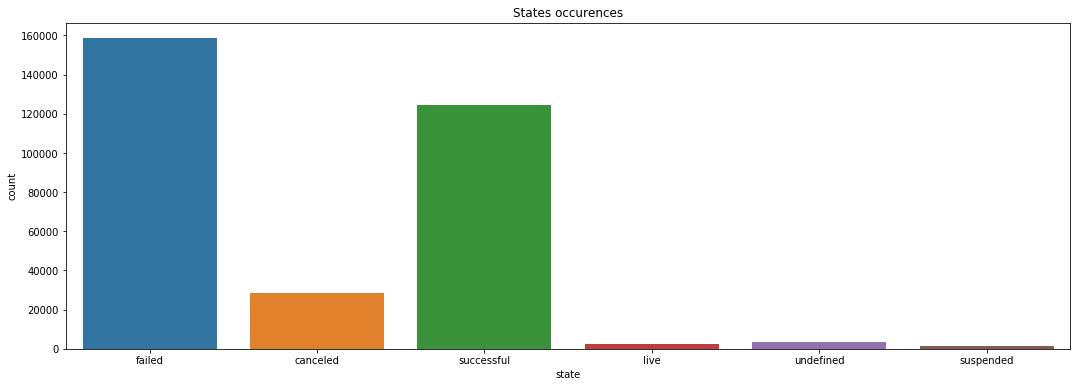

In [16]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.countplot(df['state'], ax=ax).set_title('States occurences');

We'll only keep the final states: `failed` and `successful`.

In [17]:
df = df.loc[(df['state'] == "successful") | (df['state'] == "failed")]

print(sum(df['state'] == "successful") / df.shape[0], sum(df['state'] == "failed") / df.shape[0])

0.4397907793152649 0.5602092206847351


A feature that would be interesting to create is the time people had to support the project.

In [18]:
from datetime import datetime

df["launched"] = pd.to_datetime(df.launched)
df["deadline"] = pd.to_datetime(df.deadline)

df['time_period'] = (df['deadline'] - df['launched']).dt.days

We could also create a feature for the month of launch but let's check if it would be relevant first.

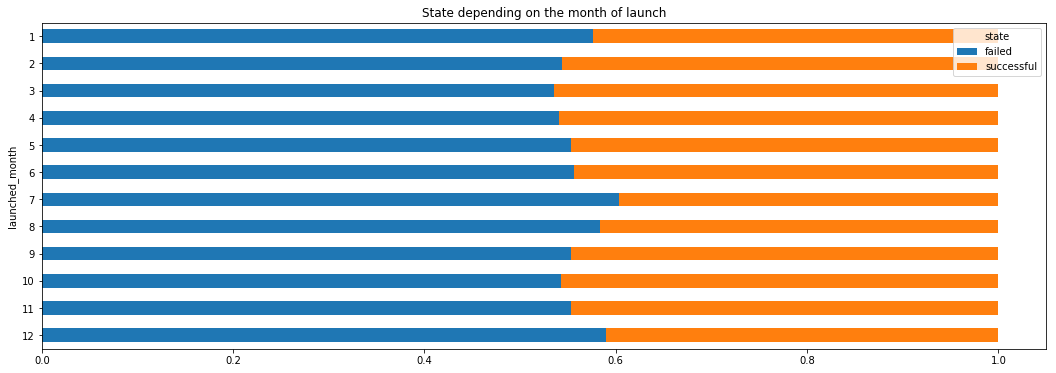

In [19]:
df['launched_month'] = df.launched.dt.month

a = df.groupby('launched_month')
a = a['state'].value_counts(normalize=True).unstack()
a = a.sort_values(by=['launched_month'],ascending=False)
a.plot(kind='barh', stacked=True, figsize=(18,6), title="State depending on the month of launch");

July and December tend to be the worst months to launch a project, probably because of summer holidays and christmas. Let's keep this new feature.

Now let's try to figure out things from project's names. We could check if its length affects the final states.

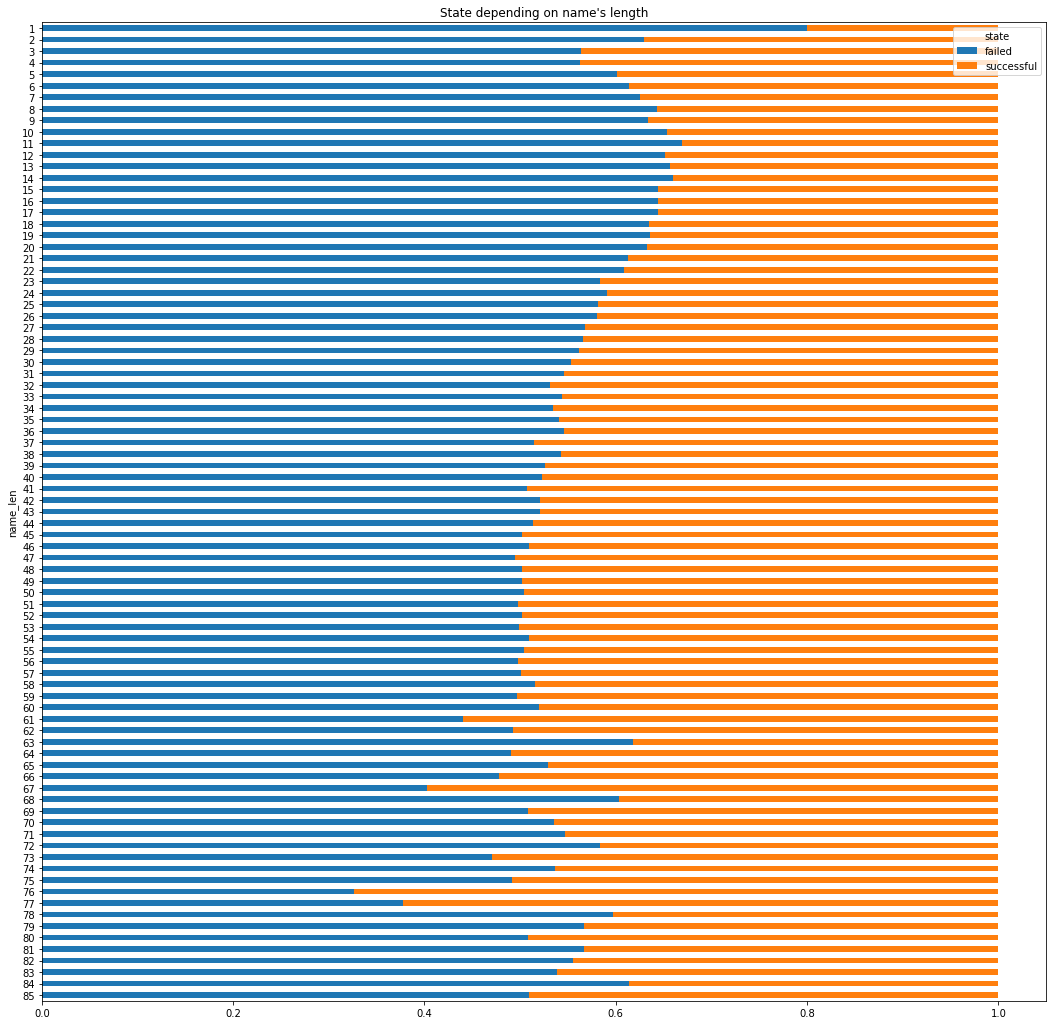

In [20]:
#Create the feature
df['name_len'] = df['name'].str.len()

#Visualize state depending on name's length
a = df.groupby('name_len')
a = a['state'].value_counts(normalize=True).unstack()
a = a.sort_values(by=['name_len'],ascending=False)
a.plot(kind='barh', stacked=True, figsize=(18,18), title="State depending on name's length");

We can see that the name of the projects can't exceed 85 letters, otherwise they are canceled. These projects won't help our predictive model as they are out of kickstarter rules. Let's remove them.

In [21]:
df.drop(df[df['name_len'] > 85].index, inplace=True)

In [22]:
#Reformat categorical features so they can be used in the models
df["category"] = df["category"].astype("category").cat.codes
df["main_category"] = df["main_category"].astype("category").cat.codes
df["currency"] = df["currency"].astype("category").cat.codes
df["country"] = df["country"].astype("category").cat.codes
#df["state"] = df["state"].astype("category").cat.codes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283146 entries, 1000002330 to 999988282
Data columns (total 13 columns):
name              283146 non-null object
category          283146 non-null int16
main_category     283146 non-null int8
currency          283146 non-null int8
deadline          283146 non-null datetime64[ns]
launched          283146 non-null datetime64[ns]
state             283146 non-null object
backers           283146 non-null int64
country           283146 non-null int8
usd_goal_real     283146 non-null float64
time_period       283146 non-null int64
launched_month    283146 non-null int64
name_len          283146 non-null int64
dtypes: datetime64[ns](2), float64(1), int16(1), int64(4), int8(3), object(2)
memory usage: 23.0+ MB


In [23]:
#Scaling data
from sklearn import preprocessing

scaled_df = df.loc[:, ['name_len', 'launched_month', 'currency', 'time_period', 'usd_goal_real', 'backers', 'category', 'main_category', 'country']]
names = scaled_df.columns
scaler = preprocessing.StandardScaler()

scaled_df = scaler.fit_transform(scaled_df)
scaled_df = pd.DataFrame(scaled_df, columns=names)

### d. Correlations and dimensionality reductions <a id="three-d"></a>

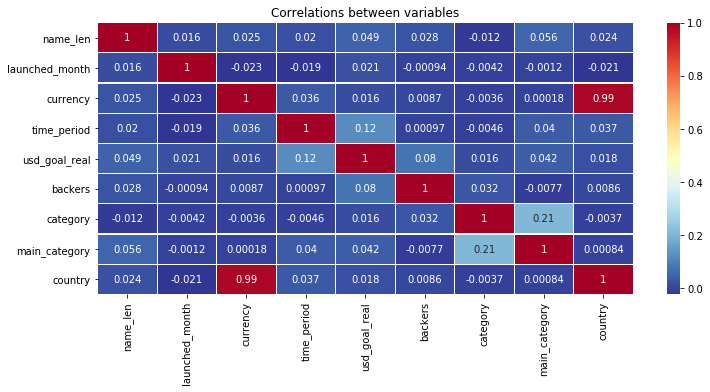

In [24]:
#Correlations between variables
fig, ax = plt.subplots(figsize=(12,5))  
sns.heatmap(data=scaled_df.corr(), annot=True, cmap = plt.cm.RdYlBu_r, linewidths=.1, ax=ax).set_title('Correlations between variables');

Currencies and countries are highly correlated. We'll only keep countries because they provide a more precise information.

## IV. Model selection <a id="four"></a>

### a. Split <a id="four-a"></a>

In [25]:
#Split the labeled data frame into two sets: features and target
X = df.loc[:, ['name_len', 'launched_month', 'time_period', 'usd_goal_real', 'backers', 'category', 'main_category', 'country']]
y = df.loc[:, 'state']

In [26]:
#Split the labeled data frame into two sets to train then test the models
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((226516, 8), (226516,), (56630, 8), (56630,))

### b. Models <a id="four-b"></a>

In [27]:
#%%time
#from sklearn.ensemble import RandomForestClassifier

#rf_model = RandomForestClassifier(n_estimators=20)
#rf_model.fit(X_train, y_train)
#print(rf_model.score(X_train, y_train), rf_model.score(X_test, y_test))

In [28]:
#%%time
#from sklearn.tree import DecisionTreeClassifier

#dt_model = DecisionTreeClassifier(max_depth=10)
#dt_model.fit(X_train, y_train)
#print(dt_model.score(X_train, y_train), dt_model.score(X_test, y_test))

In [29]:
#%%time
#import xgboost as xgb
#from xgboost.sklearn import XGBClassifier

#xgb_model = xgb.XGBClassifier()
#xgb_model.fit(X_train, y_train)
#print(xgb_model.score(X_train, y_train), xgb_model.score(X_test, y_test))

In [30]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(n_estimators=100)
gb_model.fit(X_train, y_train)
print(gb_model.score(X_train, y_train), gb_model.score(X_test, y_test))

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


0.9280668915220117 0.9266113367473071
CPU times: user 24.3 s, sys: 627 ms, total: 25 s
Wall time: 25.3 s


### c. Cross-validation <a id="four-c"></a>

In [35]:
from sklearn.model_selection import cross_val_score

cv_score = cross_val_score(gb_model, X_train, y_train, cv=5, scoring="accuracy")
print(cv_score)
print(np.mean(cv_score))

[0.9294985  0.92634042 0.92625212 0.92605346 0.92881266]
0.9273914332450431


∆R (s, t) = max s∈Σ ∆R (s, t)

In [34]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(gb_model, X_train, y_train, cv=3)

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred)

array([[117479,   9417],
       [  6993,  92627]])

## V. Hyperparameters tuning <a id="five"></a>

In [ ]:
#params = 



## VI. Training and predictions <a id="six"></a>

In [ ]:
%%time
#Training on all labeled data using the best parameters found with GridSearchCV.
gb_model = GradientBoostingClassifier(best_params)
gb_model.fit(X_train, y_train)